# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**План работы:**
1. Подготовка данных(Обработка пропусков, Обработка аномальных значений, подготовка данных к обучению моделей)
2. Обучение моделей
3. Анализ моделей и выбор лучшей

**Мы имеем:**


Исторические данные с техническими характеристиками и ценой авто на вторичном рынке

**Требуется:**

Построить модель для предсказания цены. Заказчику важны - качество предсказания, скорость предсказания, время обучения

**Описание данных:**

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

rs = 42 # random_state

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
def camel_to_snake(str, sep='_'): #преобразование столбцов в змеиный регистр
    snake_register = ''
    for i in str:
        if i.isupper():
            snake_register += sep + i.lower()
        else:
            snake_register += i
    return snake_register.lstrip(sep)
col = []
for i in df.columns:
    col.append(camel_to_snake(i))
df.columns = col

**Столбцы со следующей информацией:**
1. дата скачивания анкеты из базы
2. почтовый индекс владельца анкеты (так как у нас нет информции по регионам)
3. количество фотографий автомобиля
4. последняя активность пользователя
**Не имеют ценности для моделей. Их проще удалить**

In [5]:
fordrop = ['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen'] #Неинформативные столбцы
df = df.drop(fordrop, axis = 1)

**Точная дата создания объявления не нужна. Вполне хватит месяца и года**

In [6]:
df['year_created'] = pd.to_datetime(df['date_created'], format="%Y-%m-%dT%H:%M:%S").dt.year
df['month_created'] = pd.to_datetime(df['date_created'], format="%Y-%m-%dT%H:%M:%S").dt.month
df = df.drop('date_created', axis = 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        316879 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             334536 non-null  object
 4   power               354369 non-null  int64 
 5   model               334664 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           321474 non-null  object
 9   brand               354369 non-null  object
 10  not_repaired        283215 non-null  object
 11  year_created        354369 non-null  int64 
 12  month_created       354369 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 35.1+ MB


**Так как нет возможности заполнить пропуски - заменим их константным значением "unknown"**

In [8]:
df = df.fillna('unknown')

**Уберем редкие признаки**

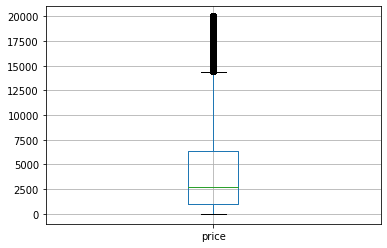

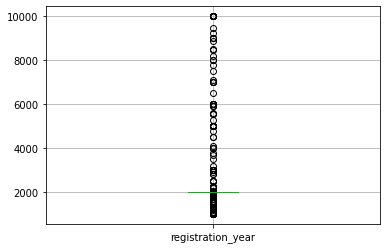

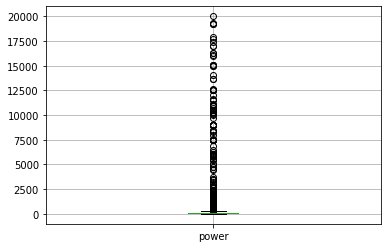

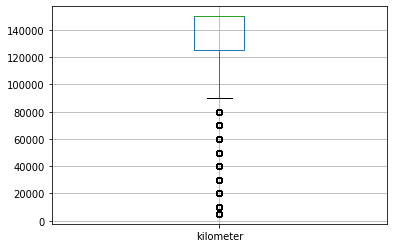

In [9]:
for i in ['price', 'registration_year', 'power', 'kilometer']:
    df.boxplot(i)
    
    plt.show()

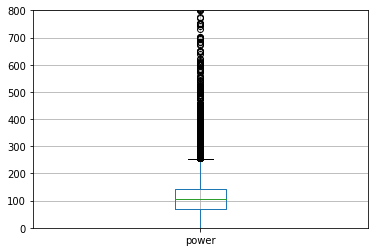

In [10]:
df.boxplot('power')# без лимитов не видно
plt.ylim(0, 800)
plt.show()

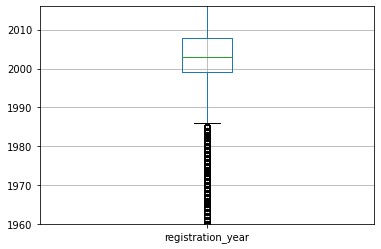

In [11]:
df.boxplot('registration_year')# без лимитов не видно 
plt.ylim(1960, 2016)
plt.show()

In [12]:
df = df.loc[(df['price'] < 15500)&(df['price'] > 500)]
df = df.loc[(df['registration_year'] > 1982)&(df['registration_year'] < 2016)]
df = df.loc[(df['power'] < 300)&(df['power'] > 30)]
df = df.loc[df['kilometer'] > 80000]

In [13]:
df = df.reset_index(drop = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216546 entries, 0 to 216545
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               216546 non-null  int64 
 1   vehicle_type        216546 non-null  object
 2   registration_year   216546 non-null  int64 
 3   gearbox             216546 non-null  object
 4   power               216546 non-null  int64 
 5   model               216546 non-null  object
 6   kilometer           216546 non-null  int64 
 7   registration_month  216546 non-null  int64 
 8   fuel_type           216546 non-null  object
 9   brand               216546 non-null  object
 10  not_repaired        216546 non-null  object
 11  year_created        216546 non-null  int64 
 12  month_created       216546 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 21.5+ MB


**Подготовим таблицу к обучению моделей**

In [15]:
#df = pd.get_dummies(df)
from sklearn.preprocessing import OrdinalEncoder
categories = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
enc = OrdinalEncoder()
enc.fit(df[categories])
df[categories] = enc.transform(df[categories])

**Разделим на таргеты и фичи и так же на тренировочную и тестовую выборки**

In [16]:
target = df['price']
features = df.drop('price', axis = 1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=rs)

**И проведем масштабирование количественных признаков**

In [17]:
scal_columns = ['power', 'kilometer', 'year_created', 'registration_year']
scaler = StandardScaler()
scaler.fit(features_train[scal_columns])
features_train[scal_columns] = scaler.transform(features_train[scal_columns])
features_test[scal_columns] = scaler.transform(features_test[scal_columns])

/tmp/ipykernel_435/843301306.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[scal_columns] = scaler.transform(features_train[scal_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_435/843301306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

## Обучение моделей

**LGBMRegressor через random search**

In [18]:
model_LGBM = LGBMRegressor(random_state = rs)
n_estimators = [int(x) for x in np.linspace(100, 200, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
LGBM_random = RandomizedSearchCV(estimator = model_LGBM, param_distributions = random_grid,
                                 cv = 3, verbose=2, random_state=rs, n_jobs = -1 , scoring = 'neg_mean_squared_error')
LGBM_random.fit(features_train, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................max_depth=50, n_estimators=144; total time= 7.9min
[CV] END .....................max_depth=50, n_estimators=144; total time= 7.7min
[CV] END .....................max_depth=50, n_estimators=144; total time=10.0min
[CV] END .....................max_depth=50, n_estimators=177; total time=12.1min
[CV] END .....................max_depth=50, n_estimators=177; total time=12.0min
[CV] END .....................max_depth=50, n_estimators=177; total time= 9.5min
[CV] END .....................max_depth=10, n_estimators=144; total time= 7.5min
[CV] END .....................max_depth=10, n_estimators=144; total time= 9.5min
[CV] END .....................max_depth=10, n_estimators=144; total time= 7.4min
[CV] END .....................max_depth=60, n_estimators=155; total time= 8.4min
[CV] END .....................max_depth=60, n_estimators=155; total time= 8.3min
[CV] END .....................max_depth=60, n_es

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'n_estimators': [100, 111, 122, 133,
                                                         144, 155, 166, 177,
                                                         188, 200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [19]:
print('Лучшие параметры', LGBM_random.best_params_)
print('Лучший результат', abs(LGBM_random.best_score_) ** 0.5)

Лучшие параметры {'n_estimators': 177, 'max_depth': 50}
Лучший результат 1327.370047131827


In [20]:
%%time
pred_LGBM = LGBM_random.predict(features_test) #предсказание

CPU times: user 675 ms, sys: 7.44 ms, total: 683 ms
Wall time: 690 ms


In [21]:
RMSE_LGBM = mean_squared_error(target_test, pred_LGBM, squared=False)
print('RMSE = ', RMSE_LGBM)

RMSE =  1322.0962123289853


---

**LinearRegression**

In [22]:
model_LR = LinearRegression()
RMSE_crossval  = cross_val_score(model_LR, features_train, target_train, cv=5, scoring = 'neg_mean_squared_error')
mse_to_rmse = []
for i in RMSE_crossval:
    mse_to_rmse.append(abs(i) ** 0.5)
mean_rmse_LR = np.mean(mse_to_rmse)
print('средний RMSE методом cross_val_score длф linear regression', mean_rmse_LR)

средний RMSE методом cross_val_score длф linear regression 2148.1168661920565


*LinearRegression на тестовой выборке*

In [23]:
%%time
model_LR.fit(features_train, target_train,) #обучение

CPU times: user 78.8 ms, sys: 39.1 ms, total: 118 ms
Wall time: 124 ms


LinearRegression()

In [24]:
%%time
pred_LR = model_LR.predict(features_test) #предсказание

CPU times: user 22 ms, sys: 7.87 ms, total: 29.9 ms
Wall time: 9.39 ms


In [25]:
RMSE_LR = mean_squared_error(target_test, pred_LR, squared=False)
print('RMSE = ', RMSE_LR)

RMSE =  2143.956370326591


---

**CatBoostRegressor**

In [26]:
model_cat = CatBoostRegressor(iterations=800, verbose=100, early_stopping_rounds=100, 
                              random_state = rs)
RMSE_crossval  = cross_val_score(model_cat, features_train, target_train, cv=5, scoring = 'neg_mean_squared_error')
mse_to_rmse = []
for i in RMSE_crossval:
    mse_to_rmse.append(abs(i) ** 0.5)
mean_rmse_cat = np.mean(mse_to_rmse)
print('средний RMSE методом cross_val_score для catboost', mean_rmse_cat)

Learning rate set to 0.105909
0:	learn: 3192.6503255	total: 84ms	remaining: 1m 7s
100:	learn: 1425.5384359	total: 1.92s	remaining: 13.3s
200:	learn: 1361.1332663	total: 3.69s	remaining: 11s
300:	learn: 1325.8140700	total: 5.44s	remaining: 9.02s
400:	learn: 1301.8223868	total: 7.38s	remaining: 7.34s
500:	learn: 1284.2277862	total: 9.16s	remaining: 5.47s
600:	learn: 1269.7503242	total: 11s	remaining: 3.65s
700:	learn: 1257.0962679	total: 12.8s	remaining: 1.8s
799:	learn: 1246.5945771	total: 14.6s	remaining: 0us
Learning rate set to 0.105909
0:	learn: 3190.5866225	total: 18.6ms	remaining: 14.9s
100:	learn: 1427.9667919	total: 1.97s	remaining: 13.7s
200:	learn: 1365.3519146	total: 4.05s	remaining: 12.1s
300:	learn: 1329.7142872	total: 5.85s	remaining: 9.69s
400:	learn: 1307.3384666	total: 8.11s	remaining: 8.07s
500:	learn: 1288.6491569	total: 10.9s	remaining: 6.51s
600:	learn: 1273.3250643	total: 13.6s	remaining: 4.52s
700:	learn: 1260.9056432	total: 15.5s	remaining: 2.19s
799:	learn: 1250

*catboost на тестовой выборке*

In [27]:
%%time
model_cat.fit(features_train, target_train,) #обучение

Learning rate set to 0.109709
0:	learn: 3181.7503228	total: 26ms	remaining: 20.8s
100:	learn: 1423.6548108	total: 2.22s	remaining: 15.4s
200:	learn: 1359.3159808	total: 4.67s	remaining: 13.9s
300:	learn: 1327.0046498	total: 6.97s	remaining: 11.5s
400:	learn: 1304.5872827	total: 9.25s	remaining: 9.2s
500:	learn: 1286.7601343	total: 11.6s	remaining: 6.91s
600:	learn: 1273.2098811	total: 13.7s	remaining: 4.55s
700:	learn: 1261.7616738	total: 15.9s	remaining: 2.25s
799:	learn: 1251.7998493	total: 18.1s	remaining: 0us
CPU times: user 18.2 s, sys: 113 ms, total: 18.3 s
Wall time: 18.9 s


In [28]:
%%time
pred_cat = model_cat.predict(features_test) #предсказание

CPU times: user 50.7 ms, sys: 31 µs, total: 50.7 ms
Wall time: 48.4 ms


In [29]:
RMSE_cat = mean_squared_error(target_test, pred_cat, squared=False)
print('RMSE = ', RMSE_cat)

RMSE =  1295.0011034539796


## Анализ моделей

In [36]:
print('RMSE кросс-валидацией и на тесте')
pd.DataFrame({'RMSE моделей на тесте': {'LGBMRegressor' : RMSE_LGBM, 'LinearRegression': RMSE_LR,
                               'CatBoostRegressor':RMSE_cat},
              'RMSE моделей кросс-валидацией':{'LGBMRegressor' : ( abs(LGBM_random.best_score_) ** 0.5), 
                                               'LinearRegression': mean_rmse_LR, 
                                               'CatBoostRegressor':mean_rmse_cat}}).T


RMSE кросс-валидацией и на тесте


,LGBMRegressor,LinearRegression,CatBoostRegressor
RMSE моделей на тесте,1322.096212,2143.956370,1295.001103
RMSE моделей кросс-валидацией,1327.370047,2148.116866,1304.476909


**По качеству предсказания стоит отбросить LinearRegression. RMSE ниже проходного уровня в 2500, но гораздо выше, чем у других 2х моделей**

In [38]:
time = pd.DataFrame({'Время обучения': ['11.6m', '71.8ms', '17.2s'], 'время предсказания': ['637ms', '49ms', '49ms']}).T
time.columns = ['LGBMRegressor','LinearRegression', 'CatBoostRegressor']

In [39]:
print('Время на обучение и предсказания')
time

Время на обучение и предсказания


,LGBMRegressor,LinearRegression,CatBoostRegressor
Время обучения,11.6m,71.8ms,17.2s
время предсказания,637ms,49ms,49ms


**Исходя из времени обучения, можно сказать, что лучшая модель - CatBoostRegressor с параметрами - iterations - 800, verbose - 100, early_stopping_rounds - 100. Она оказалась лучшей как по RMSE кросс-валидацией, так и по тесту. Время обучения у нее оказалось намного ниже, чем у LGBMRegressor - 17 секунд против 11 минут. Время предсказания CatBoostRegressor так же - 49ms против 637ms у LGBMRegressor.**